設施 和 當事者區分(類別) （腳踏自行車） 是否有關聯

In [58]:
import os
import pandas as pd

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
analyze_path = os.path.join(parent_dir, "utils")

os.chdir(analyze_path)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Arial Unicode Ms']

In [ ]:
from utils import read_data, read_taiwan_specific
import geopandas as gpd
from shapely.geometry import Point

In [ ]:
combined_data = read_data()

In [ ]:
TM2 = 3826
taiwan, grid_filter = read_taiwan_specific()
taiwan_cnty = taiwan[['COUNTYNAME','geometry']].dissolve(by='COUNTYNAME')
taiwan_cnty['geometry'] = taiwan_cnty.buffer(0)
cnty = taiwan_cnty.reset_index()

gdf_points = gpd.GeoDataFrame(combined_data, 
                              geometry=[Point(xy) for xy in zip(combined_data['經度'], combined_data['緯度'])],
                              crs='EPSG:4326').to_crs(3826)

gdf_joined = gpd.sjoin(gdf_points, cnty[['COUNTYNAME', 'geometry']], how='left', predicate='within')
combined_data['COUNTYNAME'] = gdf_joined['COUNTYNAME'].values

In [ ]:
def create_crosstab(data, type='大', scale='100'):
    type_name = f'當事者區分-類別-{type}類別名稱-車種'
    table = pd.crosstab(
        data[type_name],
        data[f'youbike_{scale}m_count'],
        normalize='index'
    )
    raw_counts = pd.crosstab(data[type_name], data[f'youbike_{scale}m_count'])
    row_sum = raw_counts.sum(axis=1)
    table = table[row_sum > 30]

    return table.sort_values(by=0, ascending=True)

In [ ]:
c1 = create_crosstab(combined_data, type='子', scale='100')
c1 = c1[c1.columns[c1.columns != 0]].sum(axis=1)

c1.plot(kind='barh', color='#36AA5B', figsize=(8, 6))
plt.xlabel('Ratio')
plt.grid(axis='x')
plt.tight_layout()

### Correlation between facilities and different variables

In [60]:
from utils_eda import BicycleFacilityAnalyzer, youbike_bin
countys = ['臺北市', '新北市', '臺中市', '高雄市', '臺東縣', '花蓮縣']
# countys = ['新竹市', '桃園市', '嘉義市', '臺南市']
# countys = combined_data.COUNTYNAME.unique().tolist()

In [ ]:
from config import countycity_dct

analyzer = BicycleFacilityAnalyzer(result=combined_data, countycity_dct=countycity_dct, countys_lst=countys)
analyzer.get_facility_ration(cols='當事者區分-類別-子類別名稱-車種', attr='腳踏自行車')
analyzer.plot_facility_accident_ratio(ylabel='Bicycle Accident Ratio')

In [ ]:
analyzer = BicycleFacilityAnalyzer(result=combined_data, countycity_dct=countycity_dct, countys_lst=countys)
analyzer.get_facility_ration(cols='事故類型及型態大類別名稱', attr='人與車')
analyzer.plot_facility_accident_ratio(ylabel='Pedestrian-Vehicle Ratio')

In [ ]:
analyzer = BicycleFacilityAnalyzer(result=combined_data, countycity_dct=countycity_dct, countys_lst=countys)
analyzer.get_facility_ration(cols='車道劃分設施-分向設施子類別名稱', attr='無分向設施')
analyzer.plot_facility_accident_ratio(ylabel='No Directional Facility Ratio')

In [ ]:
analyzer = BicycleFacilityAnalyzer(result=combined_data, countycity_dct=countycity_dct, countys_lst=countys)
analyzer.get_facility_ration(cols='號誌-號誌種類名稱', attr='無號誌')
analyzer.plot_facility_accident_ratio(ylabel='No Traffic Signal Ratio')

In [ ]:
analyzer = BicycleFacilityAnalyzer(result=combined_data, countycity_dct=countycity_dct, countys_lst=countys)
analyzer.get_facility_ration(cols='事故類型及型態大類別名稱', attr='車與車')
analyzer.plot_facility_accident_ratio(ylabel='Vehicle-Vehicle Ratio')

In [ ]:
# calculate mean '速限-第1當事者' per COUNTYNAME
mean_speed_limits = combined_data.groupby('COUNTYNAME')['速限-第1當事者'].mean()

# plot
# mean_speed_limits = mean_speed_limits.map(countycity_dct)
mean_speed_limits = mean_speed_limits.reindex(countys)
mean_speed_limits.plot(kind='bar', color='#FF5733', figsize=(8, 6))
plt.ylabel('Mean Speed Limit (km/h)')
plt.grid(axis='y')
plt.tight_layout()

In [61]:
# from utils_eda import speed_bin

def speed_bin(data):
    bins = [0, 50, 60, float("inf")]
    labels = ["<50", "50-59", ">=60"]

    data['速限-第1當事者'] = pd.cut(
        data['速限-第1當事者'],
        bins=bins,
        right=False,
        labels=labels
    )

    return data['速限-第1當事者']

data = combined_data[combined_data['COUNTYNAME'].isin(countys)].copy()
data['速限-第1當事者'] = speed_bin(data)
# COUNTYNAME, 速限-第1當事者 count
country_speed = data.groupby(['COUNTYNAME', '速限-第1當事者']).size().unstack(fill_value=0)
# normalize per COUNTYNAME
country_speed = country_speed.div(country_speed.sum(axis=1), axis=0)

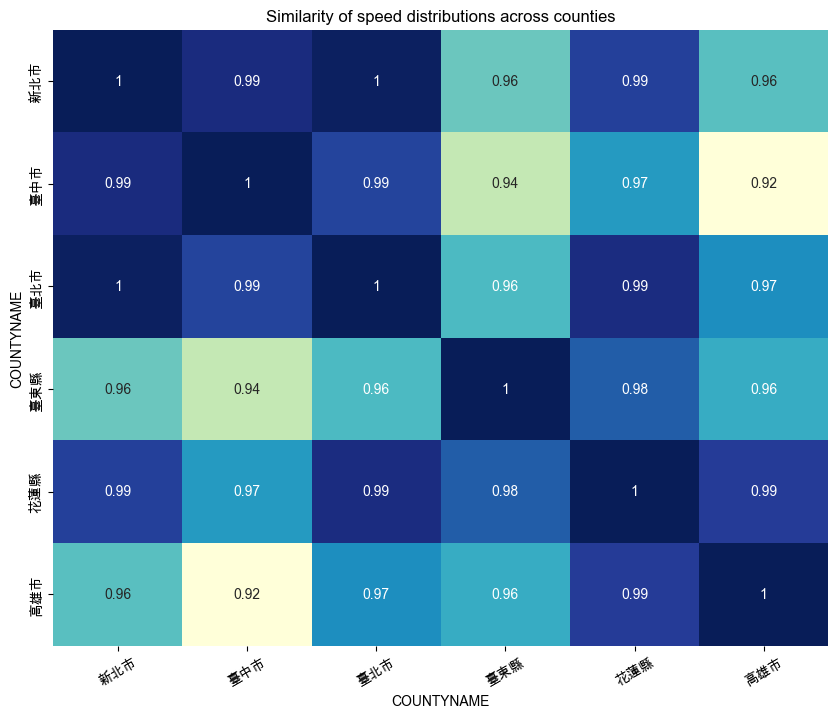

In [62]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

similarity_matrix = pd.DataFrame(
    cosine_similarity(country_speed.values),
    index=country_speed.index,
    columns=country_speed.index
)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='YlGnBu', cbar=False)
plt.title('Similarity of speed distributions across counties')
plt.xticks(rotation=30)
plt.show()

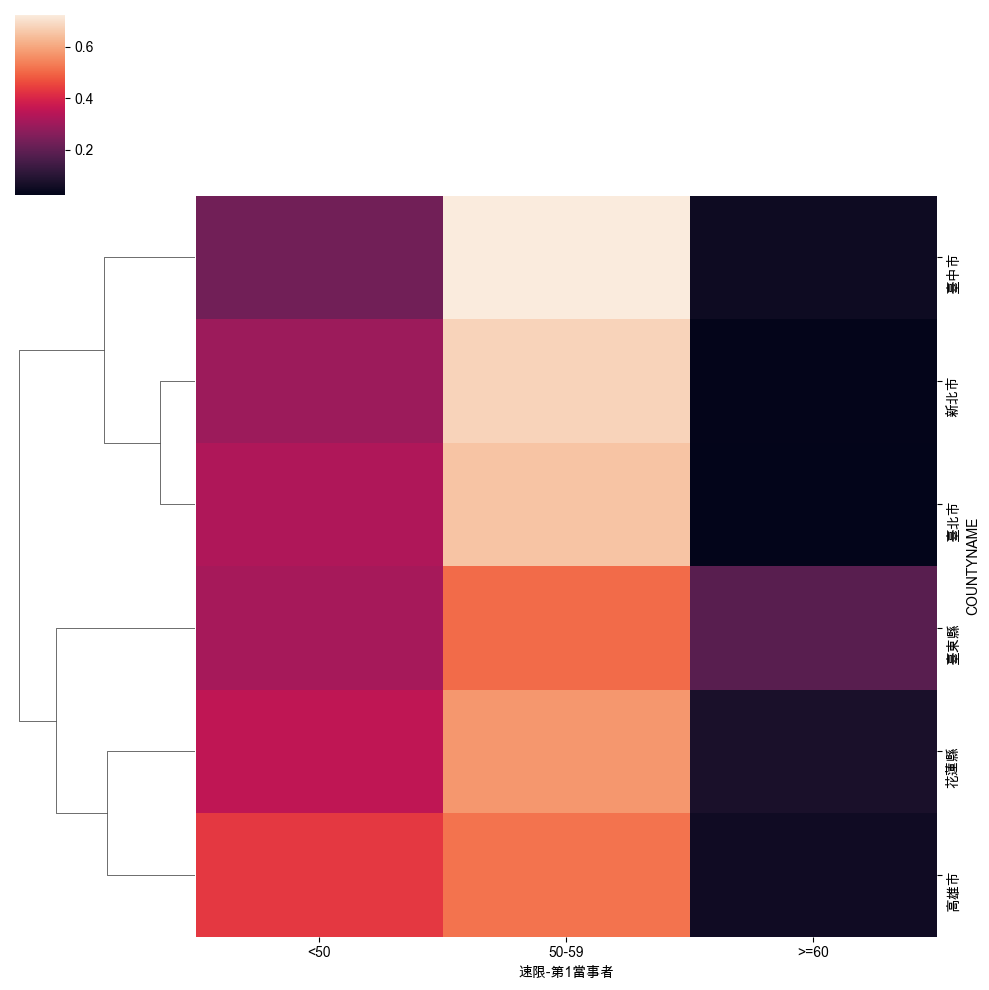

In [63]:
import seaborn as sns
# hierarchically-clustered heatmap
# https://seaborn.pydata.org/generated/seaborn.clustermap.html
g = sns.clustermap(country_speed, col_cluster=False)
# y cluster is clustering rows (COUNTYNAME)
# x cluster is clustering columns (速限-第1當事者)